In [1]:
!pip install pandas
!pip install faker
!pip install pymongo
!pip install matplotlib
!pip install streamlit

In [2]:
import pandas as pd
from faker import Faker
import pymongo
import matplotlib.pyplot as plt
import streamlit as st
import random
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import importlib.util
import sys

module_name = "config"
file_path = "/content/config.py"

spec = importlib.util.spec_from_file_location(module_name, file_path)
config = importlib.util.module_from_spec(spec)
sys.modules[module_name] = config
spec.loader.exec_module(config)



In [4]:
from config import uri_mongo
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
client = MongoClient(uri_mongo,server_api=ServerApi('1'))
!ls -a

.  ..  .config	config.py  drive  __pycache__  sample_data


In [5]:
fake=Faker()
db=client["ecommerce"]
clients_col=db["clients"]
commandes_col=db["commandes"]

In [6]:
clients_col.delete_many({})
commandes_col.delete_many({})

DeleteResult({'n': 11294, 'electionId': ObjectId('7fffffff0000000000000038'), 'opTime': {'ts': Timestamp(1746426820, 329), 't': 56}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1746426820, 329), 'signature': {'hash': b'\x93\xd7\x9e\xa6\xbeP\x8f1VC\x89\xd8M\xacN)\xaa\xd0\xb20', 'keyId': 7464295776219299841}}, 'operationTime': Timestamp(1746426820, 329)}, acknowledged=True)

In [7]:
#Générer les produits
produits=[
    {"nom":"T-shirt","catégorie":"Vêtements","prix":20},
    {"nom":"Jean","catégorie":"Vêtements","prix":45},
    {"nom":"Basket","catégorie":"Chaussures","prix":70},
    {"nom":"Bracelet","catégorie":"Accessoires","prix":18},
    {"nom":"Collier","catégorie":"Accessoires","prix":25},
    {"nom":"Sac à main", "catégorie":"Bagagerie", "prix":20},
    {"nom":"Sac à dos", "catégorie":"Bagagerie", "prix":30},
    {"nom":"Montre", "catégorie":"Accessoires", "prix":90},
    {"nom":"Full Korean skincare", "catégorie":"Beauté", "prix":120},
    {"nom":"Chargeur", "catégorie":"Informatique","prix":15},

]

In [8]:
clients=[]
for i in range(100):
  client={
  "nom":fake.last_name(),
  "prenom":fake.first_name(),
  "adresse":fake.address(),
  "ville":fake.city(),
  "code_postal":fake.postcode(),
  "pays":fake.country(),
  "email":fake.email(),
  "telephone":fake.phone_number(),
  }
  client_id=clients_col.insert_one(client).inserted_id
  clients.append({"_id": client_id, **client})

In [9]:
commandes=[]
moyen_paiement=["Carte bancaire", "Paypal", "Virement", "Apple Pay"]
code_promo=[None,"WELCOME10","SALES20","FREESHIP"]
for i in range(2000):
  client=random.choice(clients)
  nb_produits=random.randint(1, len(produits))
  produit_commande=[]
  montant_totale=0
  for j in range(nb_produits):
    produit=random.choice(produits)
    quantite= random.randint(1,5)
    prix=produit["prix"]
    montant=round(prix*quantite,2)
    produit_commande.append({
        "nom":produit["nom"],
        "prix_unitaire":prix,
        "quantite":quantite,
        "montant":montant
    })
    montant_totale+=montant
    date=fake.date_between(start_date='-6M', end_date='today')
    commande={
        "client_id":client["_id"],
        "date":date.isoformat(),
        "email":client["email"],
        "pays":client["pays"],
        "produits":produit_commande,
        "moyen_paiement":random.choice(moyen_paiement),
        "code_promo":random.choice(code_promo),
        "montant_totale":montant_totale

    }
    commandes.append(commande)
commandes_col.insert_many(commandes)

for doc in commandes_col.find().limit(3):
   print(doc)


{'_id': ObjectId('68185bd31a4b5111ef88ce29'), 'client_id': ObjectId('68185bcf1a4b5111ef88ce10'), 'date': '2025-01-29', 'email': 'webstertraci@example.org', 'pays': 'Uruguay', 'produits': [{'nom': 'Chargeur', 'prix_unitaire': 15, 'quantite': 3, 'montant': 45}, {'nom': 'Sac à main', 'prix_unitaire': 20, 'quantite': 3, 'montant': 60}, {'nom': 'T-shirt', 'prix_unitaire': 20, 'quantite': 1, 'montant': 20}, {'nom': 'Sac à main', 'prix_unitaire': 20, 'quantite': 2, 'montant': 40}], 'moyen_paiement': 'Apple Pay', 'code_promo': None, 'montant_totale': 45}
{'_id': ObjectId('68185bd31a4b5111ef88ce2a'), 'client_id': ObjectId('68185bcf1a4b5111ef88ce10'), 'date': '2024-11-30', 'email': 'webstertraci@example.org', 'pays': 'Uruguay', 'produits': [{'nom': 'Chargeur', 'prix_unitaire': 15, 'quantite': 3, 'montant': 45}, {'nom': 'Sac à main', 'prix_unitaire': 20, 'quantite': 3, 'montant': 60}, {'nom': 'T-shirt', 'prix_unitaire': 20, 'quantite': 1, 'montant': 20}, {'nom': 'Sac à main', 'prix_unitaire': 20,

In [10]:
#KPIs
#Chiffres d'affaires
pipeline = [
    {
        "$group": {
            "_id": "$pays",
            "chiffre_affaires": { "$sum": "$montant_totale" },
            "nb_commandes": { "$sum": 1 }
        }
    },
    {
        "$sort": { "chiffre_affaires": -1 }
    }
]

resultat = list(commandes_col.aggregate(pipeline))

for doc in resultat:
    print(f"{doc['_id']} : {round(doc['chiffre_affaires'], 2)} € sur {doc['nb_commandes']} commandes.")

Saint Helena : 223523 € sur 393 commandes.
Nicaragua : 169060 € sur 262 commandes.
Saint Kitts and Nevis : 155292 € sur 277 commandes.
Palau : 150874 € sur 240 commandes.
Sudan : 145381 € sur 235 commandes.
American Samoa : 134039 € sur 230 commandes.
Antarctica (the territory South of 60 deg S) : 124410 € sur 220 commandes.
Cape Verde : 121689 € sur 212 commandes.
Norfolk Island : 120663 € sur 196 commandes.
Greece : 108924 € sur 193 commandes.
Puerto Rico : 95592 € sur 184 commandes.
French Guiana : 95260 € sur 142 commandes.
Costa Rica : 91152 € sur 151 commandes.
South Georgia and the South Sandwich Islands : 91097 € sur 162 commandes.
Tuvalu : 90149 € sur 141 commandes.
Afghanistan : 89735 € sur 134 commandes.
United States of America : 85156 € sur 146 commandes.
Saudi Arabia : 84933 € sur 151 commandes.
Croatia : 83055 € sur 136 commandes.
Botswana : 81948 € sur 144 commandes.
Estonia : 81522 € sur 159 commandes.
Philippines : 79807 € sur 135 commandes.
United Kingdom : 76690 € s

In [11]:
#Top 10 clients

pipeline=[
    {
        "$group":{
            "_id":"$client_id",
            "montant_total":{"$sum":"$montant_totale"},
            "nb_commandes":{"$sum":1}
        }
    },
    {
        "$sort":{"montant_total":-1}
    },
    {"$limit":10},
    {
        "$lookup":{
            "from":"clients",
            "localField":"_id",
            "foreignField":"_id",
            "as":"client"
    }},
    {"$unwind":"$client"},
    {"$project":{
        "nom":"$client.nom",
        "prenom":"$client.prenom",
        "email": "$client.email",
        "adresse":"$client.adresse",
        "ville":"$client.ville",
        "pays":"$client.pays",
        "chiffre_affaires":"$montant_total",
        "nb_commandes":"$nb_commandes"
    }}
]
top_clients=list(commandes_col.aggregate(pipeline))
for client in top_clients:
  print(f"{client['nom']} {client['prenom']} ({client['email']}) - {client['adresse']}, {client['ville']}, {client['pays']} - {round(client['chiffre_affaires'],2)} EUR sur {client['nb_commandes']} commandes.")


George Rebecca (afrench@example.org) - 655 Villa Valleys Suite 107
Smithville, FL 71522, Parkerport, Cape Verde - 121689 EUR sur 212 commandes.
Morgan Dalton (julieharris@example.net) - 9108 James Pike Apt. 855
Port Johntown, KY 98304, North Susanport, French Guiana - 95260 EUR sur 142 commandes.
Hunter Meagan (seanjarvis@example.net) - 6819 Ashley Pine
New Ashleyville, MO 38445, Reyesburgh, Costa Rica - 91152 EUR sur 151 commandes.
Andrade Laura (taylorelliott@example.com) - 3367 Phillips View
Delacruzview, OK 47897, Lake Kevinshire, South Georgia and the South Sandwich Islands - 91097 EUR sur 162 commandes.
Berry Paul (hkhan@example.com) - 49976 Adkins Curve Apt. 122
Cindyton, SC 74348, Tracyshire, Nicaragua - 90358 EUR sur 136 commandes.
Martinez John (xphillips@example.net) - 3611 Fletcher Fields Apt. 389
South Judithhaven, IL 05456, Pinedabury, Tuvalu - 90149 EUR sur 141 commandes.
Francis Amber (qguerrero@example.com) - 237 Stanley Club Suite 241
Lake Elizabeth, PR 20820, Harrisp

In [12]:
#Regrouper par pays
pipeline=[
    {
        "$group":{
            "_id":"$pays",
            "chiffre_affaires":{"$sum":"$montant_totale"},
            "nb_commandes":{"$sum":1}
        }
    },
    {

          "$sort":{"chiffre_affaires":-1}

    }
]
resultat=list(commandes_col.aggregate(pipeline))
for doc in commandes_col.find().limit(5):
  print(doc["pays"])
for doc in resultat:
  if doc['chiffre_affaires'] is not None:
    print(f"{doc['_id']}:{doc['chiffre_affaires']}€ sur {doc['nb_commandes']} commandes")
  else:
    print(f"{doc['_id']}: Aucun chiffre d'affaires")

Uruguay
Uruguay
Uruguay
Uruguay
French Polynesia
Saint Helena:223523€ sur 393 commandes
Nicaragua:169060€ sur 262 commandes
Saint Kitts and Nevis:155292€ sur 277 commandes
Palau:150874€ sur 240 commandes
Sudan:145381€ sur 235 commandes
American Samoa:134039€ sur 230 commandes
Antarctica (the territory South of 60 deg S):124410€ sur 220 commandes
Cape Verde:121689€ sur 212 commandes
Norfolk Island:120663€ sur 196 commandes
Greece:108924€ sur 193 commandes
Puerto Rico:95592€ sur 184 commandes
French Guiana:95260€ sur 142 commandes
Costa Rica:91152€ sur 151 commandes
South Georgia and the South Sandwich Islands:91097€ sur 162 commandes
Tuvalu:90149€ sur 141 commandes
Afghanistan:89735€ sur 134 commandes
United States of America:85156€ sur 146 commandes
Saudi Arabia:84933€ sur 151 commandes
Croatia:83055€ sur 136 commandes
Botswana:81948€ sur 144 commandes
Estonia:81522€ sur 159 commandes
Philippines:79807€ sur 135 commandes
United Kingdom:76690€ sur 130 commandes
Micronesia:75937€ sur 123

In [13]:
#panier moyen
pipeline=[
    {
          "$group":{
              "_id":None,
              "total_montant":{"$sum":"$montant_totale"},
              "total_commandes":{"$sum":1}
          }
      },
      {
          "$project":{
              "_id":0,
              "panier_moyen":{"$divide": ["$total_montant","$total_commandes"]
              },
              "total_montant":1,
              "total_commandes":1
          }
      }
]

resultat = list(commandes_col.aggregate(pipeline))

if resultat:  # Vérifie qu'il y a au moins un document
    panier_moyen = round(resultat[0]["panier_moyen"], 2)
    print(f"Le panier moyen est : {panier_moyen} EUR")
else:
    print("Aucune commande trouvée.")

Le panier moyen est : 538.72 EUR


In [14]:
#panier moyen par mois

pipeline=[
    {
        "$group":{
            "_id": {"$substr":["$date",0,7]},
            "nb_commandes": {"$sum":1},
            "chiffre_affaires":{"$sum":"$montant_totale"},
        }
    },
    {
        "$project":{
            "nb_commandes":1,
            "chiffre_affaires":1,
            "panier_moyen":{"$divide":["$chiffre_affaires","$nb_commandes"]}
        }
    },
    {
        "$sort":{"_id":1}
    }
]
resultat=list(commandes_col.aggregate(pipeline))
for ligne in resultat:
  print(f"{ligne['_id']} : {ligne['nb_commandes']} commandes - {round(ligne['chiffre_affaires'],2)} EUR - panier moyen {round(ligne['panier_moyen'],2)}")

#dataframe pour panier moyen et affichage

2024-11 : 1672 commandes - 896119 EUR - panier moyen 535.96
2024-12 : 1879 commandes - 984669 EUR - panier moyen 524.04
2025-01 : 1887 commandes - 1037066 EUR - panier moyen 549.58
2025-02 : 1658 commandes - 908508 EUR - panier moyen 547.95
2025-03 : 1924 commandes - 1050584 EUR - panier moyen 546.04
2025-04 : 1778 commandes - 944718 EUR - panier moyen 531.34
2025-05 : 239 commandes - 124232 EUR - panier moyen 519.8


In [15]:
#Segmentation des clients
pipeline=[
    {
        "$group":{
            "_id":"$client_id",
            "chiffre_affaires":{"$sum":"$montant_totale"},
            "nb_commandes":{"$sum":1},
            "nb_commandes_promos":{
                "$sum":{
                    "$cond":[{"$ne":["$code_promo",None]},1,0]}} #si le code promo est diff de None alors compte 1 sinon 0
        }
    },
    {
        "$project":{
            "nb_commandes":1,
            "chiffre_affaires":1,
            "code_promo":1,
            "panier_moyen":{"$round":[{"$divide":["$chiffre_affaires","$nb_commandes"]},2]},
            "ratio_code_promos": {"$round":[{"$divide":["$nb_commandes_promos","$nb_commandes"]},2]
        }}
    },
    {
        "$lookup":{
            "from":"clients",
            "localField":"_id",
            "foreignField":"_id",
            "as":"client"
        }
    },
    {
        "$unwind":"$client"
    },
    #Affichage
    {
        "$project":{
            "client_id":"$_id",
            "nom":"$client.nom",
            "prenom":"$client.prenom",
            "pays":"$client.pays",
            "email":"$client.email",
            "chiffre_affaires":1,
            "nb_commandes":1,
            "panier_moyen":1,
            "ratio_code_promos":1
        }
    }
]

resultat = list(commandes_col.aggregate(pipeline))
df_comportement=pd.DataFrame(resultat)
colonnes=["client_id","nom","prenom","pays","email","chiffre_affaires","nb_commandes","panier_moyen","ratio_code_promos"]
df=df_comportement[colonnes]
df_clients = pd.DataFrame(resultat)

print(df["chiffre_affaires"].describe())
print(df["nb_commandes"].describe())
print(df["panier_moyen"].describe())
print(df["ratio_code_promos"].describe())

count       100.000000
mean      59458.960000
std       19047.669783
min       21851.000000
25%       45815.750000
50%       58537.500000
75%       72152.000000
max      121689.000000
Name: chiffre_affaires, dtype: float64
count    100.000000
mean     110.370000
std       26.959624
min       50.000000
25%       94.000000
50%      110.000000
75%      129.000000
max      212.000000
Name: nb_commandes, dtype: float64
count    100.000000
mean     530.713000
std       73.453386
min      378.720000
25%      485.960000
50%      533.140000
75%      590.230000
max      670.850000
Name: panier_moyen, dtype: float64
count    100.000000
mean       0.749000
std        0.043935
min        0.610000
25%        0.720000
50%        0.750000
75%        0.780000
max        0.830000
Name: ratio_code_promos, dtype: float64


In [16]:
#Segmentation profil
df = pd.DataFrame(resultat)

def profiler(row):
  if row["chiffre_affaires"]>=1000 and row["nb_commandes"]>=130:
    return "VIP"
  if row["ratio_code_promos"]>=0.765 and row["nb_commandes"]>=115:
    return "Promo addict"
  if row["nb_commandes"]>=90:
    return "Régulier"
  else:
    return "Occasionnel"

df["profil"]=df.apply(profiler, axis=1)
df.head(10)

# Affichage
df[["client_id", "chiffre_affaires", "nb_commandes", "profil"]].head(10)

,client_id,chiffre_affaires,nb_commandes,profil
0,68185bd01a4b5111ef88ce16,39899,89,Occasionnel
1,68185bc71a4b5111ef88cdc7,21851,50,Occasionnel
2,68185bcb1a4b5111ef88cde6,55202,110,Régulier
3,68185bc91a4b5111ef88cdce,39372,94,Régulier
4,68185bce1a4b5111ef88ce03,24238,64,Occasionnel
5,68185bcd1a4b5111ef88ce00,58524,118,Promo addict
6,68185bcc1a4b5111ef88cdf0,61159,121,Régulier
7,68185bca1a4b5111ef88cdd9,69062,129,Promo addict
8,68185bd01a4b5111ef88ce1e,32306,76,Occasionnel
9,68185bcb1a4b5111ef88cde5,91097,162,VIP


In [17]:
#Dernier achat:
pipeline=[
    {
        "$group":{
            "_id":"$client_id",
            "dernier_achat":{"$max":"$date"}
        }
    }
]
resultat = list(commandes_col.aggregate(pipeline))

df_dates=pd.DataFrame(resultat)
df_dates.rename(columns={"_id":"client_id"}, inplace=True)

#Nombre de jour depuis le dernier achat
today = pd.Timestamp(datetime.today())
df_dates["dernier_achat"]=pd.to_datetime(df_dates["dernier_achat"])
df_dates["duree_dernier_achat"]=today-df_dates["dernier_achat"]
df_dates

,client_id,dernier_achat,duree_dernier_achat
0,68185bce1a4b5111ef88ce07,2025-05-04,1 days 06:34:03.733575
1,68185bc91a4b5111ef88cdcf,2025-05-04,1 days 06:34:03.733575
2,68185bca1a4b5111ef88cddf,2025-05-04,1 days 06:34:03.733575
3,68185bcb1a4b5111ef88cde3,2025-05-04,1 days 06:34:03.733575
4,68185bcf1a4b5111ef88ce13,2025-05-02,3 days 06:34:03.733575
...,...,...,...
95,68185bce1a4b5111ef88ce08,2025-05-04,1 days 06:34:03.733575
96,68185bc81a4b5111ef88cdcd,2025-05-02,3 days 06:34:03.733575
97,68185bc91a4b5111ef88cdd5,2025-05-01,4 days 06:34:03.733575
98,68185bd11a4b5111ef88ce23,2025-05-01,4 days 06:34:03.733575


In [18]:
#Compter produits distincts achetés par client
pipeline=[
    {"$unwind":"$produits"},
    {
        "$group":{
          "_id":{"client":"$client_id","produit":"$produits.nom"}
      }
    },
    {
        "$group": {
            "_id": "$_id.client",
            "produits_uniques": { "$addToSet": "$_id.produit" }
        }
    },
    {
        "$project": {
            "nb_produits_distincts": { "$size": "$produits_uniques" }
        }
    }
]

resultat = list(commandes_col.aggregate(pipeline))
df_produits = pd.DataFrame(resultat)
df_produits.rename(columns={"_id": "client_id"}, inplace=True)
df_produits.head()

,client_id,nb_produits_distincts
0,68185bcf1a4b5111ef88ce14,10
1,68185bd11a4b5111ef88ce25,10
2,68185bd01a4b5111ef88ce1c,10
3,68185bd11a4b5111ef88ce21,10
4,68185bce1a4b5111ef88ce05,10


In [19]:
client_id = commandes_col.find_one({}, {"client_id": 1})["client_id"]

# Récupère tous les produits commandés par ce client
produits_commandes = set()
for commande in commandes_col.find({"client_id": client_id}):
    for p in commande["produits"]:
        produits_commandes.add(p["nom"])

print("Produits achetés :", produits_commandes)
print("Total distincts :", len(produits_commandes))


Produits achetés : {'Basket', 'T-shirt', 'Collier', 'Bracelet', 'Full Korean skincare', 'Montre', 'Chargeur', 'Sac à dos', 'Jean', 'Sac à main'}
Total distincts : 10


In [20]:
df_ml = pd.merge(df_clients, df_dates, on='client_id', how='inner') #similaire join sql; how='inner' pour garder uniquement les clients qui sont dans les deux DataFrames
df_ml.head()

,_id,chiffre_affaires,nb_commandes,panier_moyen,ratio_code_promos,client_id,nom,prenom,pays,email,dernier_achat,duree_dernier_achat
0,68185bd01a4b5111ef88ce16,39899,89,448.30,0.74,68185bd01a4b5111ef88ce16,Hardy,Robert,Finland,angela81@example.com,2025-04-30,5 days 06:34:03.733575
1,68185bc71a4b5111ef88cdc7,21851,50,437.02,0.74,68185bc71a4b5111ef88cdc7,Smith,Bradley,Falkland Islands (Malvinas),edwardsashley@example.net,2025-05-04,1 days 06:34:03.733575
2,68185bcb1a4b5111ef88cde6,55202,110,501.84,0.73,68185bcb1a4b5111ef88cde6,Tate,Brandon,France,trobinson@example.net,2025-05-04,1 days 06:34:03.733575
3,68185bc91a4b5111ef88cdce,39372,94,418.85,0.61,68185bc91a4b5111ef88cdce,Bernard,Kimberly,Congo,averyrobert@example.org,2025-05-04,1 days 06:34:03.733575
4,68185bce1a4b5111ef88ce03,24238,64,378.72,0.78,68185bce1a4b5111ef88ce03,Smith,Sara,Spain,samuelbradley@example.com,2025-05-04,1 days 06:34:03.733575


In [21]:
#churn (=satisfaction client en binaire) = client n'ayant pas commandé depuis + 60j
today = pd.Timestamp(datetime.today())
df_ml["duree_dernier_achat"] = (today - df_ml["dernier_achat"]).dt.days
df_ml["churn"]=(df_ml["duree_dernier_achat"]>4).astype(int)
df_ml[["client_id", "duree_dernier_achat", "churn"]].head(50)


,client_id,duree_dernier_achat,churn
0,68185bd01a4b5111ef88ce16,5,1
1,68185bc71a4b5111ef88cdc7,1,0
2,68185bcb1a4b5111ef88cde6,1,0
3,68185bc91a4b5111ef88cdce,1,0
4,68185bce1a4b5111ef88ce03,1,0
5,68185bcd1a4b5111ef88ce00,1,0
6,68185bcc1a4b5111ef88cdf0,5,1
7,68185bca1a4b5111ef88cdd9,9,1
8,68185bd01a4b5111ef88ce1e,1,0
9,68185bcb1a4b5111ef88cde5,2,0


In [22]:
# X = toutes les colonnes sauf la cible
X = df_ml.drop(columns=["churn", "client_id", "_id"], errors='ignore')  # ignore évite l'erreur si la colonne n’existe pas
y = df_ml["churn"]


In [23]:
#Séparer les variables explicatives et la cible (qui est la colonne churn)
from sklearn.model_selection import train_test_split

X = df_ml.drop(columns=["churn", "client_id", "email", "nom", "prenom", "pays"], errors="ignore")  # X = les features
y = df_ml["churn"]  # y = la variable cible

# Séparation entre train et test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Taille du train :", X_train.shape)
print("Taille du test :", X_test.shape)
#Je sépare mes données en X (features) et y (cible). Puis je découpe entre entraînement et test avec 80%/20%.
#Le test me permet d’évaluer le modèle sur des données qu’il n’a jamais vues.

Taille du train : (80, 7)
Taille du test : (20, 7)


In [24]:
print(X.dtypes)


_id                            object
chiffre_affaires                int64
nb_commandes                    int64
panier_moyen                  float64
ratio_code_promos             float64
dernier_achat          datetime64[ns]
duree_dernier_achat             int64
dtype: object


In [25]:
# On garde uniquement les colonnes numériques
X = df_ml.drop(columns=["_id", "dernier_achat"], errors="ignore")
X = X.select_dtypes(include=["int64", "float64"])

y = df_ml["churn"]


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


In [28]:
#Utilisation modèle de classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Modèle
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Prédictions
y_pred = rf.predict(X_test)

# Résultats
print("Évaluation Random Forest :")
print(classification_report(y_test, y_pred))
#J’ai choisi Random Forest car c’est un modèle robuste, non-linéaire, qui gère bien les variables numériques,
#catégorielles (si encodées), et les interactions complexes. Il me donne aussi une idée de l’importance des variables.

Évaluation Random Forest :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00         2

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



**Classe 0 (clients fidèles)**
*Précision* : 1.00 → Tous ceux prédits comme fidèles le sont vraiment

*Recall* : 1.00 → Tous les vrais fidèles ont été détectés

*Support*: 19 → Il y avait 19 clients fidèles dans le test


**Classe 1 (clients churnés)**
*Précision* : 1.00 → Le seul client prédit comme churné l’était vraiment

*Recall* : 1.00 → Le seul churn réel a bien été trouvé

*Support* : 1 → Il n’y avait qu’un seul churn dans le test

📊 **Global**

**Métrique	Interprétation**

*accuracy* = 1.00	100% de bonnes prédictions sur les 20 cas

*macro avg* = 1.00	Moyenne entre les classes sans tenir compte du déséquilibre

*weighted avg* = 1.00	Moyenne pondérée par le nombre de cas dans chaque classe

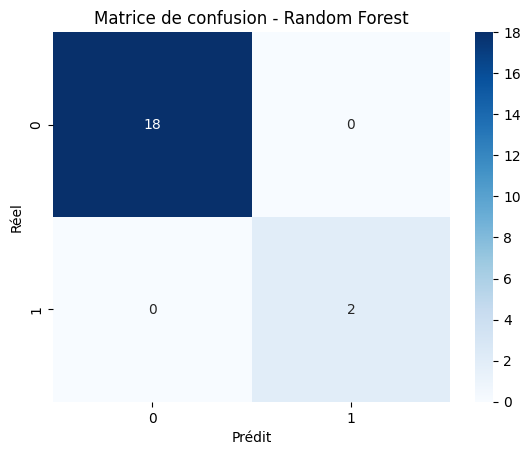

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Random Forest")
plt.show()
